<a href="https://colab.research.google.com/github/ShovalBenjer/Product_Recommendation_Forecasting/blob/main/Copy_of_Insait_DS_candidates'_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greetings!
> You received this jupyter notebook as we believe this can be a great fit. <br>
> The goal of this notebook is to understand our challenges better <br> and assess your proficiency in python & pandas.

### Several remarks:
* You are welcome to use the internet, consult, and use any available sources.
* There is no time limit, and we do not monitor any versioning or pace. Take your time and have fun.
* The notebook should take up to two hours. If it takes more than that, please reach out.
We tried to create an intriguing assignment. If you have any feedback - we'll be happy to hear.
* A text cell decorated with "👷" will be followed by a code cell you are welcome to fill in.

### **Make sure the notebook runs end to end before submission**

# **The products recommendation notebook**
The data at hand represents 12,000 bank clients and their monthly financial status.
<br> The data is featured as a tabular schema, where each row contains 48 features.
>The first 24 features are client-level entities such as age, residence country, and the joining channel.
<br>The last 24 features are the **products** the client owns in a specified month (`Status_Dt`).

Our task is to *forecast* which products a client will add or remove next month, given that we have all past information on the client.

# Logistics

In [1]:
# You will probably need to run this cell twice,
# as google colab has runtime issues after installing some libraries
# (press the "Restart runtime" button in the output cell)
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [2]:
# Download and extract the dataset
!rm -rf sample_data
!mkdir data & gdown 1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu -O data/features_products.zip
!unzip data/features_products.zip -d data/features_products
!find . -name "*.zip" ! -iname features_products.zip | while read filename; do unzip -o -d "`dirname "$filename"`" "$filename"; done;
!find . -name "*.zip" -delete

Downloading...
From (original): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu
From (redirected): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu&confirm=t&uuid=cbe1eb36-9529-4cc9-9a67-561fe5a6f1a9
To: /content/data/features_products.zip
100% 240M/240M [00:00<00:00, 263MB/s]
Archive:  data/features_products.zip
  inflating: data/features_products/sample_submission.csv.zip  
  inflating: data/features_products/test_ver2.csv.zip  
  inflating: data/features_products/train_ver2.csv.zip  
Archive:  ./data/features_products/test_ver2.csv.zip
  inflating: ./data/features_products/test_ver2.csv  
Archive:  ./data/features_products/sample_submission.csv.zip
  inflating: ./data/features_products/sample_submission.csv  
Archive:  ./data/features_products/train_ver2.csv.zip
  inflating: ./data/features_products/train_ver2.csv  


In [3]:
# Import libraries and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)
import warnings
warnings.filterwarnings("ignore")


Populating the interactive namespace from numpy and matplotlib


In [4]:
# Sample the dataset (We only want to experiment with the data).
limit_rows   = 7000000
df           = pd.read_csv("data/features_products/train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str},
                                                     nrows=limit_rows)


In [5]:
# The original schema was in Spanish. We will rename the columns for readability.
df.columns = ['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age', 'Join_Dt',
                'Is_New_Cust', 'Cust_Since', 'Relship_Status','Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg',
                'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg',
                'Address_Type', 'Cust_Province_Cd', 'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
                'Cust_Segment', 'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
                'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage', 'Pension1', 'Loans',
                'Taxes', 'Credit_Card', 'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit']

# Sample the dataset (We only want to experiment with the data).
unique_ids   = pd.Series(df["Cust_ID"].unique())
limit_people = int(1.2e4)
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.Cust_ID.isin(unique_id)]

In [6]:
# Cast relevant data types
date_attribs = ['Status_Dt', 'Join_Dt', 'Lst_Dt_Primary_Cust']
for attrib in date_attribs:
    df[attrib] = pd.to_datetime(df[attrib],format="%Y-%m-%d")
numeric_attribs = ['Age', 'Is_New_Cust', 'Cust_Since', 'Relship_Status', 'Address_Type', 'Cust_Active_Status']
for attrib in numeric_attribs:
    df[attrib] = pd.to_numeric(df[attrib], downcast='integer',errors='coerce')

# Exploratory Data Analysis 👷

### The task in this phase is to analyze the data.
#### Think of at least 3-5 useful EDA plots to present that helps understand the underlying statistics. Explain why you selected these plots. What insights/questions did you also find during the EDA?
*Remember - The goal is to predict which items customers will add in the following month.*

> You are not obligated to submit all plots and analyses you perform.
<br>Try to understand the data as good as possible.


# **Firstly - Cleaning And Encoding Analysis**

* Categorical columns with missing values not missing at random were identified as needing specific handling, since these values likely reflect meaningful customer attributes or behaviors.
* Interpolation was chosen for numeric columns to maintain continuity in time-series data, filling gaps with estimated values based on neighboring data points.
* Missing join dates required differentiated handling for new and existing customers to avoid treating all missing values uniformly.

Questions:
* Should I treat missing values in columns like Deceased_Flg and Is_Spouse_Emp as actual categories, or are they simply incomplete data that should be discarded?
* How can I ensure that the choice of interpolation for numeric columns doesn’t introduce bias, particularly in a time-series context? (if i had more time i would try to check if the data has a clear trend or pattern over time. If the data fluctuates irregularly, simple linear interpolation may not be suitable, and more advanced methods like polynomial or spline interpolation could be used)

In [7]:
print("Data types of columns in the DataFrame:")
print(df.dtypes)

Data types of columns in the DataFrame:
Status_Dt                    datetime64[ns]
Cust_ID                               int64
Emp_Status                           object
Cust_Ctry                            object
Cust_Sex                             object
Age                                 float64
Join_Dt                      datetime64[ns]
Is_New_Cust                         float64
Cust_Since                          float64
Relship_Status                      float64
Lst_Dt_Primary_Cust          datetime64[ns]
Cust_Type_Mth_Beg                    object
Cust_Relship_Type_Mth_Beg            object
Residence_Ctry                       object
Is_Foreigner                         object
Is_Spouse_Emp                        object
Join_Channel                         object
Deceased_Flg                         object
Address_Type                        float64
Cust_Province_Cd                    float64
Cust_Province_Name                   object
Cust_Active_Status                  

In [8]:
# List of categorical columns (excluding the 6 numeric and 3 date columns)
categorical_columns = [
    'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Cust_Type_Mth_Beg',
    'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner',
    'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg',
    'Cust_Province_Name', 'Cust_Segment'
]

# Print the unique values for each categorical column
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Column: {col}")
    print(f"Unique values: {unique_values}\n")

Column: Emp_Status
Unique values: ['N' nan 'A' 'F' 'B']

Column: Cust_Ctry
Unique values: ['ES' nan 'DE' 'CN' 'CL' 'FR' 'US' 'AR' 'EC' 'PT' 'MX' 'FI' 'NL' 'BR' 'JP'
 'CU' 'LU' 'CH' 'RO' 'GB' 'DO' 'BO' 'UY' 'KR' 'CO' 'PL']

Column: Cust_Sex
Unique values: ['H' 'V' nan]

Column: Cust_Type_Mth_Beg
Unique values: [1.0 nan '1.0' '1' '3.0' '3' 'P' 3.0 '2' '2.0' '4.0' 2.0]

Column: Cust_Relship_Type_Mth_Beg
Unique values: ['I' 'A' nan 'P' 'R']

Column: Residence_Ctry
Unique values: ['S' nan 'N']

Column: Is_Foreigner
Unique values: ['N' 'S' nan]

Column: Is_Spouse_Emp
Unique values: [nan]

Column: Join_Channel
Unique values: ['KHE' 'KHD' 'KFC' 'KAT' 'KFA' 'KAZ' nan 'RED' 'KHC' 'KAR' 'KFF' 'KFK'
 'KGV' 'KAH' 'KCC' 'KGX' 'KAB' 'KAA' 'KFN' 'KAG' 'KAQ' 'KAI' 'KFL' 'KFS'
 'KFJ' 'KHK' 'KHF' 'KHL' 'KHM' 'KBG' 'KCI' 'KEC' 'KDR' 'KBL' 'KAD' 'KEA'
 'KDO' 'KBU' 'KCB' '007' 'KBH' 'KAC' 'KEI' 'KCL' 'KEH' 'KDZ' 'KBR' 'KAY'
 'KBD' '013' 'KCM' 'KAS' 'KCA' 'KCG' 'KDG' 'KDU' 'KDV' 'KBY' 'KCK' 'KCN'
 'KES' 'KBZ

In [9]:
# # Calculate the percentage of missing values per column
# missing_percentage = df.isnull().mean() * 100
# print(missing_percentage)

# **First Plot - AutoCorrelation Plot Partial and AutoCorrelation Plot of Cust_since**

* The partial autocorrelation plot (PACF) indicates significant lags up to around 10, showing that Cust_Since has strong correlation with past values within a short time period.
*The autocorrelation plot (ACF) shows periodic fluctuations, suggesting cyclical or seasonal patterns.
*Next steps involve capturing these lagged dependencies by adding lagged features or using models that account for autocorrelation, such as ARIMA or LSTM, to improve predictive power.

Question: How can the periodic fluctuations observed in the autocorrelation plot be leveraged to identify potential seasonal or cyclical patterns in customer tenure, and how might these patterns affect the predictive performance of time-series models such as LSTM or ARIMA? (I didn’t have time, but I thought including seasonal components or Fourier terms could capture the periodic fluctuations, improving models like SARIMA or LSTM for long-term trend forecasting.)










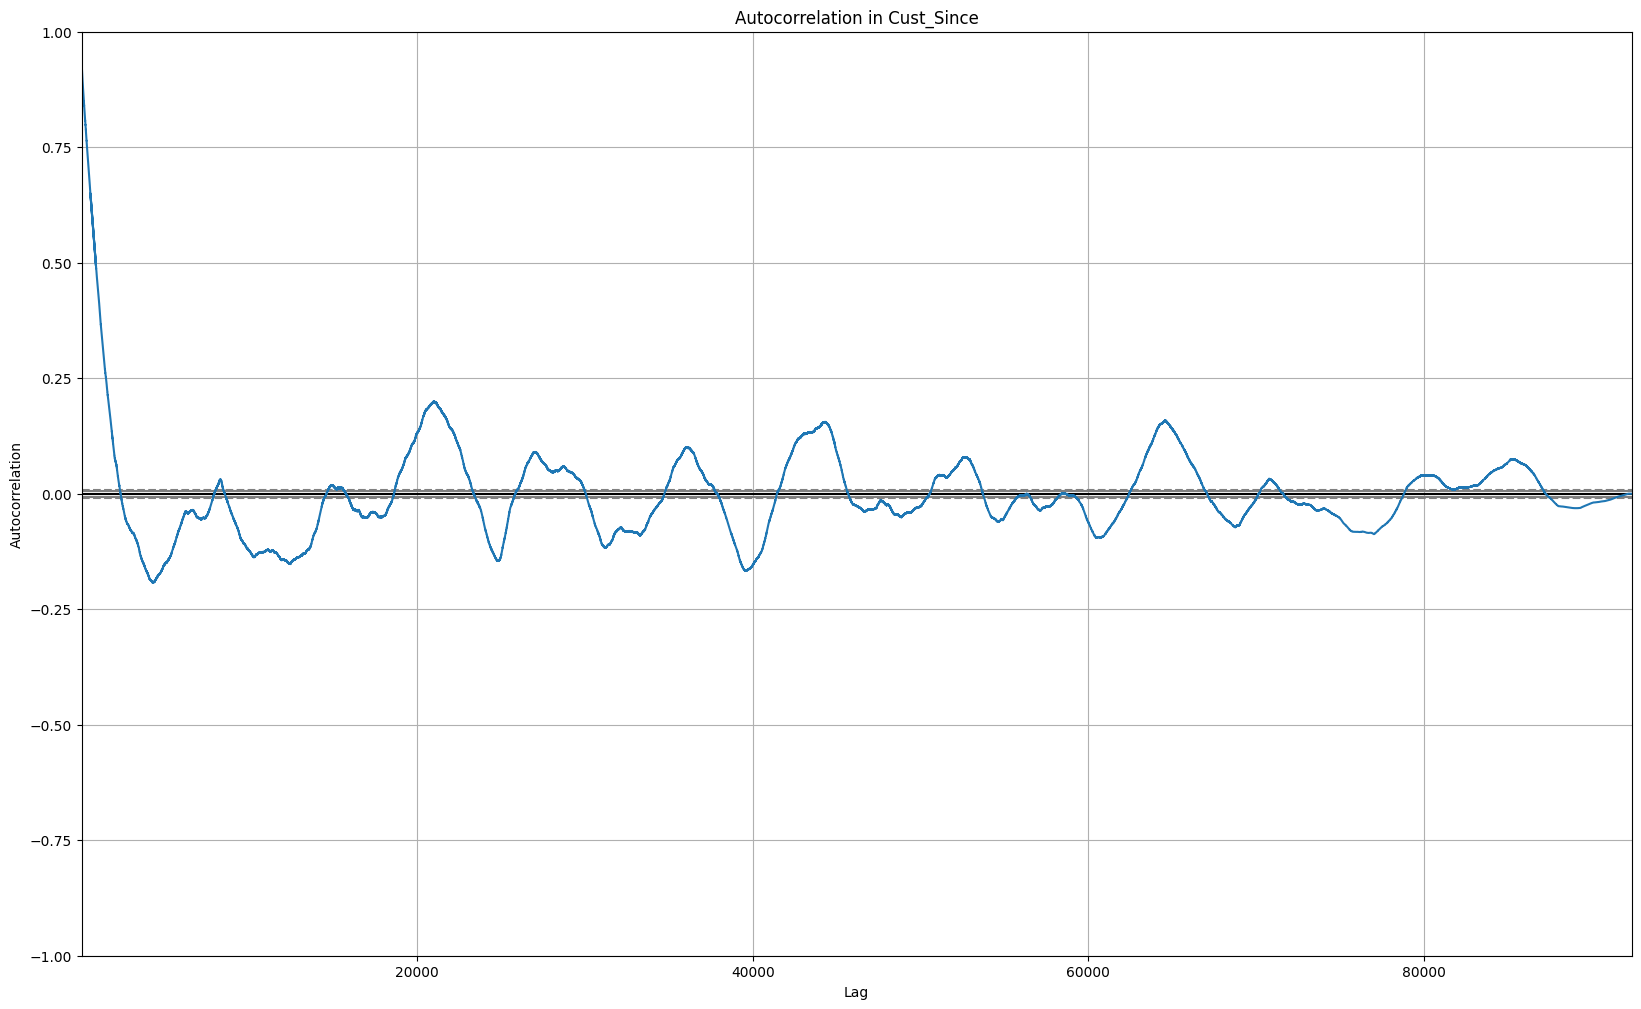

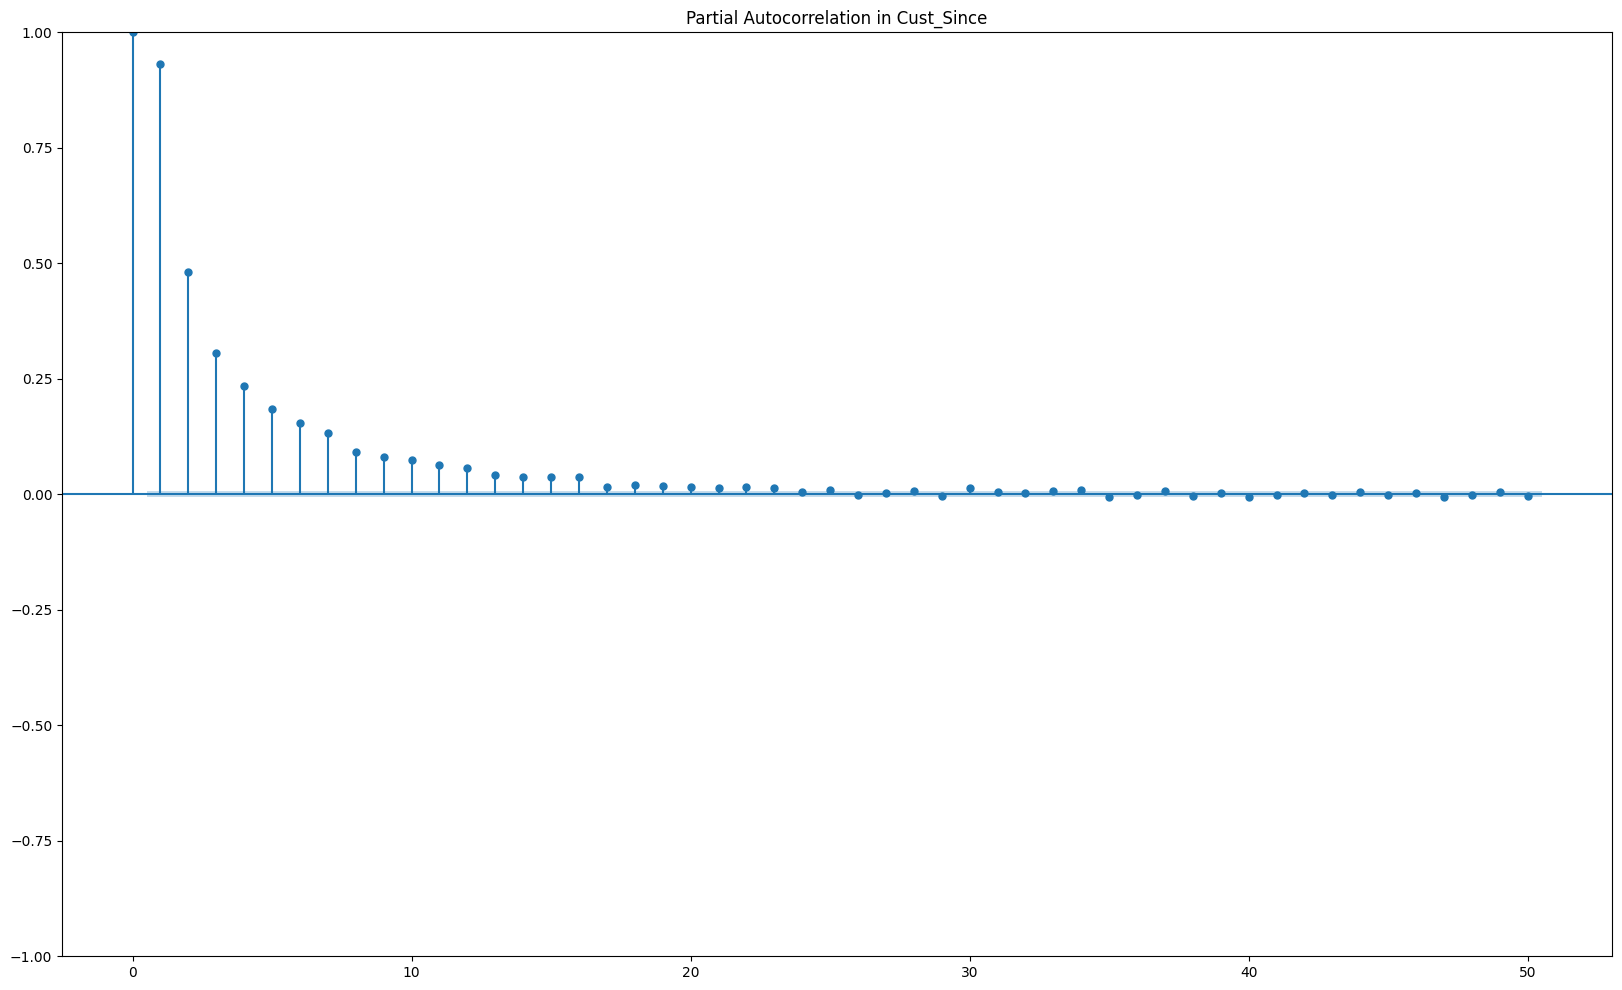

In [10]:
!pip install statsmodels

# Import necessary libraries
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation Plot for 'Cust_Since'
autocorrelation_plot(df['Cust_Since'].dropna())
plt.title('Autocorrelation in Cust_Since')
plt.show()

# Partial Autocorrelation Plot for 'Cust_Since'
plot_pacf(df['Cust_Since'].dropna(), lags=50)
plt.title('Partial Autocorrelation in Cust_Since')
plt.show()

Plot 2 - Product Ownership Trend Over time

This plot shows the trends of product ownership across different product types over time, with some products like Savings and Current Accounts having the highest number of clients, remaining relatively stable. Toward the end of the period, there is a notable decline across several products, indicating potential seasonality or external factors impacting customer behavior in the later months.









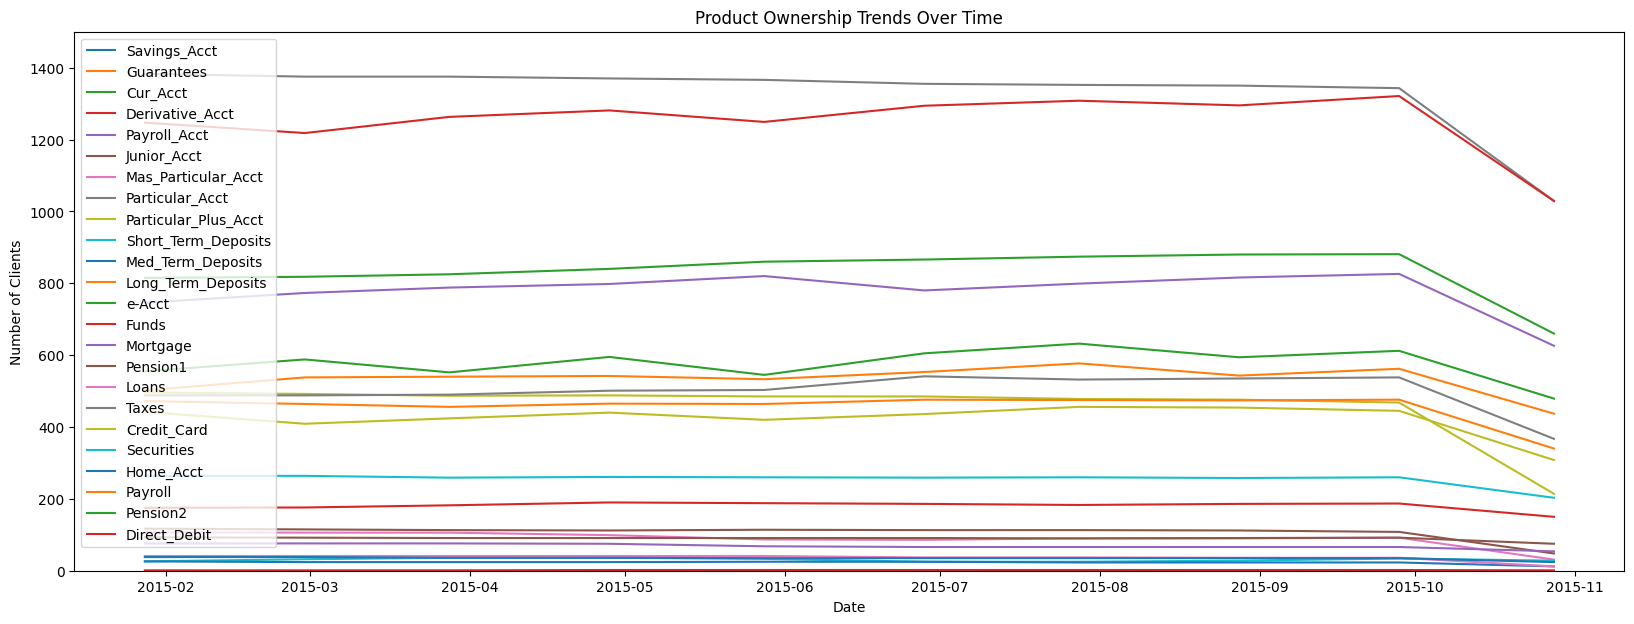

In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Group by time and count the number of clients owning each product
product_ownership = df.groupby('Status_Dt')[['Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct', 'Junior_Acct',
                                             'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                                             'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage',
                                             'Pension1', 'Loans', 'Taxes', 'Credit_Card', 'Securities', 'Home_Acct',
                                             'Payroll', 'Pension2', 'Direct_Debit']].sum()


# Adjusting the y-axis to zoom in
plt.figure(figsize=(20,7))
for column in product_ownership.columns:
    plt.plot(product_ownership.index, product_ownership[column], label=column)

plt.title('Product Ownership Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Clients')
plt.ylim(0, 1500)  # Adjust this value as needed to zoom in on the relevant range
plt.legend(loc='upper left')
plt.show()



handling missing values of categorial and numeric values

# **Plot 3 - HeatMap Correlations between Products (Target Variables)**

* Strong positive correlations exist between Payroll_Acct, Loans, and Direct_Debit, suggesting customers who own one are more likely to own the others.
* Products like Credit_Card and Taxes show weaker or negative correlations with other products, indicating they are less likely to be bundled with other services.
* Cust_Since shows moderate correlations with certain product types like  Payroll_Acct and Guarantees, potentially highlighting the role of customer tenure in product ownership.
* High correlation between Savings_Acct and Cur_Acct suggests these products are frequently held together by customers.


# **Insights (I would Proof if i had more time) - What to do with High Correlation?**
Feature reduction: Remove one of the highly correlated features (e.g., Payroll_Acct, Loans, or Direct_Debit) to reduce multicollinearity and simplify the model without losing much information.

Create interaction features: Combine highly correlated features to create interaction terms (e.g., a new feature combining Savings_Acct and Cur_Acct) that may capture more complex relationships and improve model performance.

Segment customers: Use highly correlated products to segment customers into groups, such as those who hold multiple related products, which can enhance personalized marketing or recommendation systems.





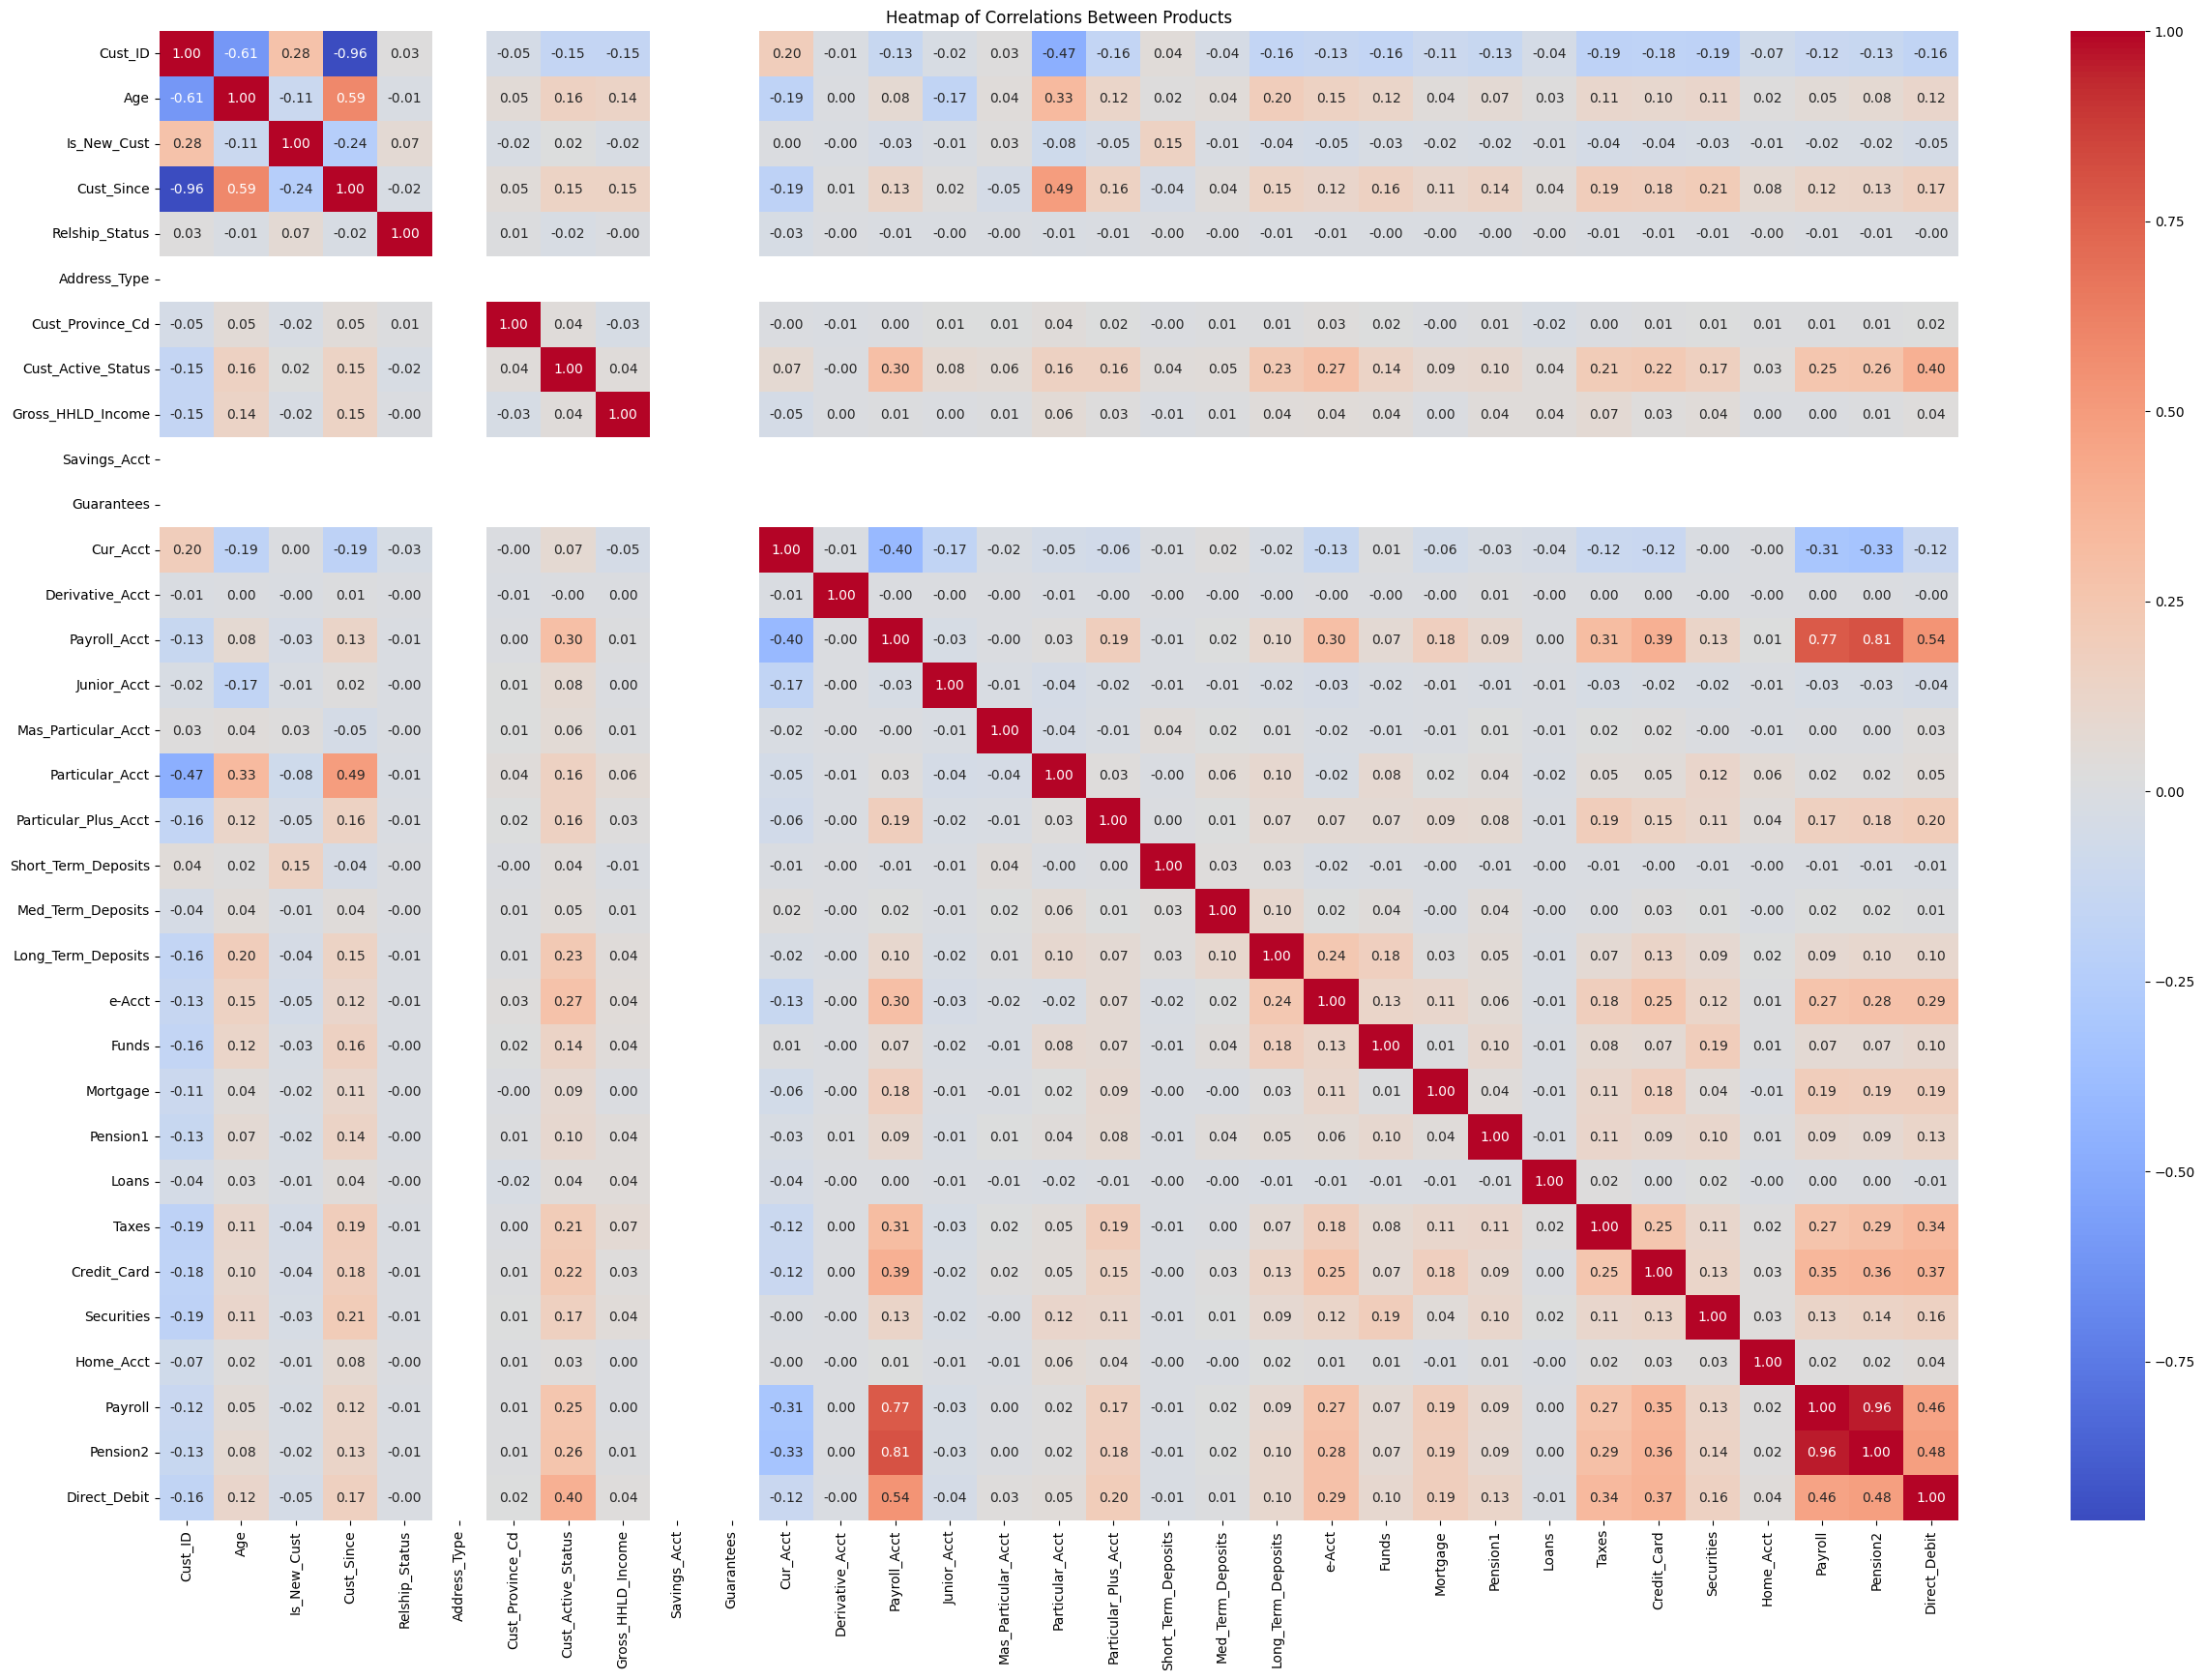

In [12]:
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap of Correlations Between Products')
plt.show()

# Let's get down, let's get down to business! 🕺💃 👷

After understanding our data better, we would like to train a model to predict the following products a client is about to add or remove.

The development will be segmented into *three* steps.

1.   Create a label vector for each month:
<br>The label vector for each `<client, date>` is the *difference* between the products the client holds in `<date>` and the products of the same client in the consecutive month.<br>
For example, if a client `X` holds a credit card, and does not have a loan or a savings account in March 2019 (translates to the vector `[1,0,0]`) and canceled the credit card in April 2019 but opened a savings account (translates to the vector `[0,0,1]`) - The label for `X, March 2019` will be `[-1,0,1].` <br><br>

2.   Use Feature engineering and Feature selection methods to enrich the training dataset.

3. Use any relevant classification algorithm to predict the shift between consecutive months.
  


## Create labels

In [126]:
# Sort the data by Cust_ID and Status_Dt to ensure proper chronological order
df_copy = df.sort_values(by=['Cust_ID', 'Status_Dt'])

# List of product columns (adjust based on your dataset)
product_columns = [
    'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
    'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct',
    'Short_Term_Deposits', 'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct',
    'Funds', 'Mortgage', 'Pension1', 'Loans', 'Taxes', 'Credit_Card',
    'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit'
]

# Shift the Status_Dt to create the shifted time column within each Cust_ID group
df_copy['Status_Dt_shifted'] = df_copy.groupby('Cust_ID')['Status_Dt'].shift(-1)

# Create shifted product columns (for each product column, shift by one time step)
for col in product_columns:
    df_copy[f'{col}_shifted'] = df_copy.groupby('Cust_ID')[col].shift(-1)

# Calculate the product changes between consecutive months (next month - current month)
for col in product_columns:
    df_copy[f'{col}_change'] = df_copy[f'{col}_shifted'] - df_copy[col]

# Optional: Fill missing values for the first instance within each Cust_ID group with 0 (indicating no change)
df_copy.fillna(0, inplace=True)

# Create the next_data_label dataframe with necessary columns
next_data_label = df_copy[['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + [f'{col}_change' for col in product_columns]]

# Check the result
next_data_label.head(5)


,Cust_ID,Status_Dt,Status_Dt_shifted,Savings_Acct_change,Guarantees_change,Cur_Acct_change,Derivative_Acct_change,Payroll_Acct_change,Junior_Acct_change,Mas_Particular_Acct_change,...,Mortgage_change,Pension1_change,Loans_change,Taxes_change,Credit_Card_change,Securities_change,Home_Acct_change,Payroll_change,Pension2_change,Direct_Debit_change
417104,16187,2015-01-28,2015-02-28 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836088,16187,2015-02-28,2015-03-28 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1673824,16187,2015-03-28,2015-04-28 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092047,16187,2015-04-28,2015-05-28 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
2933858,16187,2015-05-28,2015-06-28 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [132]:
# Because we only care about behavioural changes, we filter rows with no product change in the consecutive month.
trainable_objects = next_data_label.iloc[:,3:].any(axis=1).to_numpy().nonzero()[0]
next_data_label_relevant = next_data_label.iloc[trainable_objects]

## Create features

#### Feature engineering 👨‍🔧 📏 📝 📊
Feature engineering is a crucial part of working with tabular data.

We love new libraries and papers and try to be up-to-date as much as possible here at Insait.

Use any feature engineering method or library you know and love, and create new features to enrich your data.
You can choose to do automatic feature engineering or knowledge-based by manually thinking on logical correlations.

 Encoding Strategy:
For each categorical variable, we should evaluate whether it has an inherent order or if it’s purely nominal.
Nominal: [Cust_Ctry, Cust_Sex, Emp_Status, Residence_Ctry, Is_Foreigner, Is_Spouse_Emp, Deceased_Flg, Cust_Province_Cd, Cust_Province_Name, Join_Channel].
Logic: Since Nominal variables don’t have a natural order, we’ll apply one-hot encoding. This creates a new binary column for each unique category in the original column. The logic ensures that the model doesn’t assume any unintended order.
Execution: We'll create dummy variables using one-hot encoding for each nominal variable, ensuring that new columns are created and the original column is dropped (can be also kept by preference)
Potentially Ordinal: [Cust_Type_Mth_Beg, Cust_Relship_Type_Mth_Beg, Cust_Segment].
Logic: If the variable is ordinal, label encoding assigns a unique integer to each category based on their order. This preserves the ordinal relationship.
Execution: 1. We'll Ensure that the order is defined correctly to prevent misinterpretation.
           2. We'll apply label encoding to ordinal variables, where the categories are mapped to integers reflecting their order.
Check for Dummy Variable Trap - We'll ensure that one column from each one-hot encoded variable is dropped to avoid multicollinearity.
Verify that all categorical columns have been encoded correctly and that the dataset is ready for further analysis.


# **Cleaning**

In [133]:
# Copy the dataset for cleaning and processing
enriched_df = df.iloc[:, :24].copy()

enriched_df = enriched_df.sort_values(by=['Cust_ID', 'Status_Dt'])

# Handle missing values for categorical columns with appropriate filling strategies
enriched_df['Deceased_Flg'] = enriched_df['Deceased_Flg'].fillna(0)
enriched_df['Is_Spouse_Emp'] = enriched_df['Is_Spouse_Emp'].fillna(0)
enriched_df['Join_Channel'] = enriched_df['Join_Channel'].fillna('Missing')
enriched_df['Cust_Segment'] = enriched_df['Cust_Segment'].fillna('Missing')

# Handle other categorical columns with mode imputation
categorical_columns = ['Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Cust_Type_Mth_Beg',
                       'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry']
for col in categorical_columns:
    enriched_df[col] = enriched_df[col].fillna(enriched_df[col].mode()[0])

# Handle missing values for numeric columns using interpolation or appropriate strategies
numeric_columns = ['Age', 'Cust_Since', 'Gross_HHLD_Income']
for col in numeric_columns:
    enriched_df[col] = enriched_df[col].interpolate(method='linear')

# Handle columns with more than 95% missing data by filling with 0 or drop based on context
high_missing_columns = ['Lst_Dt_Primary_Cust', 'Is_Spouse_Emp']
for col in high_missing_columns:
    if enriched_df[col].isnull().mean() > 0.95:
        enriched_df[col] = enriched_df[col].fillna(0)

# Custom standardization for 'Cust_Type_Mth_Beg' column
def standardize_cust_type(value):
    if isinstance(value, str) and value.replace('.', '', 1).isdigit():
        return str(float(value))
    return value

enriched_df['Cust_Type_Mth_Beg'] = enriched_df['Cust_Type_Mth_Beg'].apply(standardize_cust_type)
enriched_df['Cust_Type_Mth_Beg'] = enriched_df['Cust_Type_Mth_Beg'].astype(str)


# Cust_Province_Name, Cust_Province_Cd, Address_Type - fill with '0'
enriched_df['Cust_Province_Name'] = enriched_df['Cust_Province_Name'].fillna(0)
enriched_df['Cust_Province_Cd'] = enriched_df['Cust_Province_Cd'].fillna(0)
enriched_df['Address_Type'] = enriched_df['Address_Type'].fillna(0)
enriched_df['Relship_Status'] = enriched_df['Relship_Status'].fillna(0)

# Is_Foreigner - fill missing values with False (assuming not a foreigner)
enriched_df['Is_Foreigner'] = enriched_df['Is_Foreigner'].fillna(False)

# For 'Cust_Active_Status', replace NaN with 0 (assuming inactive or "0")
enriched_df['Cust_Active_Status'] = enriched_df['Cust_Active_Status'].fillna(0)

# Handle missing values in Is_New_Cust by assuming not a new customer (0)
enriched_df['Is_New_Cust'] = enriched_df['Is_New_Cust'].fillna(0)

# Get the earliest known join date from the dataset
earliest_known_date = enriched_df['Join_Dt'].min()

# Get the oldest join date for new customers
oldest_new_customer_date = enriched_df[enriched_df['Is_New_Cust'] == 1]['Join_Dt'].min()

# Fill missing Join_Dt based on whether the customer is new or not
enriched_df.loc[enriched_df['Is_New_Cust'] == 0, 'Join_Dt'] = enriched_df['Join_Dt'].fillna(earliest_known_date)
enriched_df.loc[enriched_df['Is_New_Cust'] == 1, 'Join_Dt'] = enriched_df['Join_Dt'].fillna(oldest_new_customer_date)

# Final NaN Check
print("NaN values after final cleaning:\n", enriched_df.isnull().sum()[enriched_df.isnull().sum() > 0])


NaN values after final cleaning:
 Series([], dtype: int64)


In [134]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Ensure the datetime columns are correctly parsed as datetime objects
def convert_to_datetime(df, datetime_columns):
    for col in datetime_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')  # Convert to datetime
    return df

# Add lagged features for weekly, quarterly, and yearly intervals, then remove datetime columns
def add_lagged_features(df, datetime_columns):
    for col in datetime_columns:
        if col in df.columns:
            # Ensure the column is in datetime format
            df[col + '_week'] = df[col].dt.isocalendar().week
            df[col + '_quarter'] = df[col].dt.quarter
            df[col + '_year'] = df[col].dt.year
    return df

# Process numeric columns, handling 'Unknown' as -1 or other numeric preprocessing
def process_numeric_features(df, numeric_columns):
    for col in numeric_columns:
        if col in df.columns:
            # Fill missing values with -1 (assuming 'Unknown' represented as NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-1)
    return df

# Process categorical columns with One-Hot and Label Encoding
def process_categorical_features(df, one_hot_columns, label_columns):
    # One-Hot Encoding
    one_hot_encoded_df = pd.get_dummies(df[one_hot_columns], drop_first=True)

    # Label Encoding
    for col in label_columns:
        if col in df.columns:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Drop original one-hot columns and concatenate the one-hot encoded columns
    df = df.drop(columns=one_hot_columns)
    df = pd.concat([df, one_hot_encoded_df], axis=1)

    return df

# Specify datetime columns, numeric columns, one-hot and label encoding columns
datetime_columns = ['Status_Dt', 'Join_Dt', 'Lst_Dt_Primary_Cust']
numeric_columns = ['Age', 'Is_New_Cust', 'Cust_Since', 'Gross_HHLD_Income', 'Payroll', 'Pension2']
one_hot_columns = ['Cust_Ctry', 'Cust_Sex', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Deceased_Flg', 'Cust_Province_Name', 'Emp_Status', 'Join_Channel']
label_columns = ['Cust_Segment', 'Cust_Type_Mth_Beg', 'Cust_Relship_Type_Mth_Beg']

# Assuming 'enriched_df' is already loaded and contains the necessary columns

# Convert datetime columns to ensure they are in the correct format
enriched_df = convert_to_datetime(enriched_df, datetime_columns)

# Add lagged features and remove original datetime columns
enriched_df = add_lagged_features(enriched_df, datetime_columns)

# Process numeric columns, handling 'Unknown' as -1
enriched_df = process_numeric_features(enriched_df, numeric_columns)

# Process categorical columns with One-Hot and Label Encoding
enriched_df = process_categorical_features(enriched_df, one_hot_columns, label_columns)

# Verify the encoding process by checking the first few rows
print(enriched_df.head())


         Status_Dt  Cust_ID   Age    Join_Dt  Is_New_Cust  Cust_Since  \
417104  2015-01-28    16187  68.0 1995-03-02          0.0       245.0   
836088  2015-02-28    16187  68.0 1995-03-02          0.0       245.0   
1673824 2015-03-28    16187  68.0 1995-03-02          0.0       245.0   
2092047 2015-04-28    16187  68.0 1995-03-02          0.0       245.0   
2933858 2015-05-28    16187  68.0 1995-03-02          0.0       245.0   

         Relship_Status Lst_Dt_Primary_Cust  Cust_Type_Mth_Beg  \
417104              1.0          1970-01-01                  0   
836088              1.0          1970-01-01                  0   
1673824             1.0          1970-01-01                  0   
2092047             1.0          1970-01-01                  0   
2933858             1.0          1970-01-01                  0   

         Cust_Relship_Type_Mth_Beg  ...  Join_Channel_KHF  Join_Channel_KHK  \
417104                           0  ...             False             False   
836088

#### Feature Selection
The financial datasets we use at Insait have hundreds of columns.

Training on such massive datasets lead to bad performance and extended training time.

Suggest a feature selection method (Using an open-source library is welcomed), and filter the provided dataset

In [135]:
# Assuming next_data_label_relevant has been created and contains the change columns
# Merge the moving averages and other features from enriched_df with next_data_label_relevant

Selecting features using RFE with XGBoost for each target label separately...
Running RFE for target: Savings_Acct_change
Selected features for Savings_Acct_change: ['Join_Channel_KHO', 'Join_Channel_KHP', 'Join_Channel_KHQ', 'Join_Channel_Missing', 'Join_Channel_RED']
Running RFE for target: Guarantees_change
Selected features for Guarantees_change: ['Join_Channel_KHO', 'Join_Channel_KHP', 'Join_Channel_KHQ', 'Join_Channel_Missing', 'Join_Channel_RED']
Running RFE for target: Cur_Acct_change
Selected features for Cur_Acct_change: ['Age', 'Cust_Since', 'Status_Dt_week', 'Cust_Province_Name_SANTA CRUZ DE TENERIFE', 'Join_Channel_KHE']
Running RFE for target: Derivative_Acct_change
Selected features for Derivative_Acct_change: ['Join_Channel_KHO', 'Join_Channel_KHP', 'Join_Channel_KHQ', 'Join_Channel_Missing', 'Join_Channel_RED']
Running RFE for target: Payroll_Acct_change
Selected features for Payroll_Acct_change: ['Age', 'Cust_Active_Status', 'Gross_HHLD_Income', 'Status_Dt_week', 'Joi

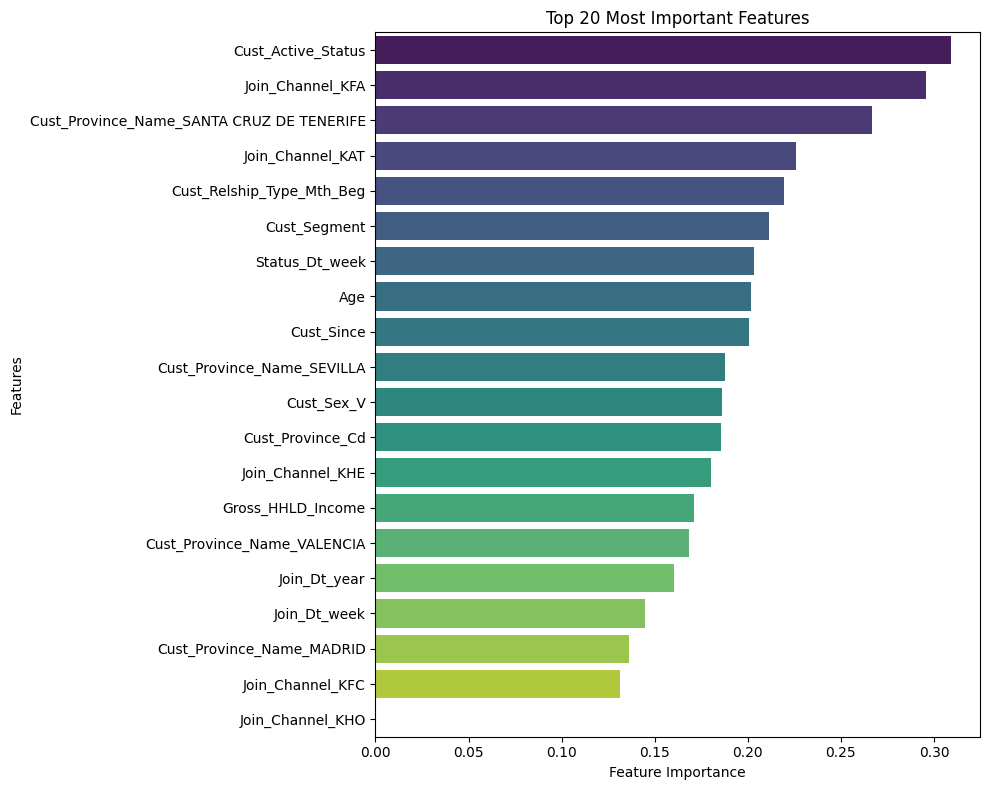

In [136]:
from xgboost import XGBClassifier
from shaphypetune import BoostRFE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Merge the cleaned enriched_df and next_data_label
merged_df = pd.merge(enriched_df, next_data_label, on=['Cust_ID', 'Status_Dt'], how='inner')

# Step 2: Use a subset of merged_df to reduce computational expense
subset_size = 5000  # Adjust this size based on your computational limits
if len(merged_df) > subset_size:
    merged_df_sub = merged_df.sample(n=subset_size, random_state=42)
else:
    merged_df_sub = merged_df

# Step 3: Prepare X (features) and y (targets - product changes)
columns_to_drop = ['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + [f'{col}_change' for col in product_columns]
X = merged_df_sub.drop(columns=columns_to_drop, errors='ignore')
y = merged_df_sub[[f'{col}_change' for col in product_columns]]

# Remap y values: -1 to 2 (removal of product), 0 (no change), 1 (addition of product)
y = y.applymap(lambda x: 2 if x == -1 else x)

# Ensure no datetime columns remain
X = X.select_dtypes(exclude=['datetime', 'timedelta'])
X.fillna(0, inplace=True)

### Recursive Feature Elimination (RFE) with XGBoost (applied separately for each target label) ###
selected_features = []
feature_importances = pd.DataFrame(columns=['Feature', 'Importance', 'Target'])

print("Selecting features using RFE with XGBoost for each target label separately...")

# Apply RFE for each target column separately
for target_label in y.columns:
    print(f"Running RFE for target: {target_label}")

    # Step 4: Check the unique values in the target column
    unique_values = y[target_label].unique()

    # Remap the values if they are [0, 2]
    if set(unique_values) == {0, 2}:
        print(f"Remapping 2 to 1 for {target_label} to fit XGBoost binary classification...")
        y[target_label] = y[target_label].replace(2, 1)

    # Step 5: Define the XGBoost model for each target
    xgb_model = XGBClassifier(
        max_depth=3,
        n_estimators=20,
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Step 6: Initialize BoostRFE for the XGBoost model
    rfe_selector = BoostRFE(
        estimator=xgb_model,
        min_features_to_select=5,              # Minimum number of features to select
        step=1,                                # Number of features to remove in each step
        param_grid=None,                       # You can add hyperparameter optimization here if needed
        greater_is_better=True,                # Whether higher score is better (e.g., for accuracy)
        importance_type='feature_importances', # Use feature importance
        n_jobs=-1,                             # Parallel jobs
        verbose=1
    )

    # Step 7: Fit the RFE feature selection process for each label
    rfe_selector.fit(X, y[target_label])

    # Step 8: Collect selected features
    selected_features_for_label = X.columns[rfe_selector.support_].tolist()
    print(f"Selected features for {target_label}: {selected_features_for_label}")

    selected_features.extend(selected_features_for_label)

    # Step 9: Collect feature importances for the selected features only
    importance = rfe_selector.estimator_.feature_importances_
    selected_features_importance = X.columns[rfe_selector.support_]
    feature_importances_for_label = pd.DataFrame({
        'Feature': selected_features_importance,
        'Importance': importance,
        'Target': target_label
    })
    feature_importances = pd.concat([feature_importances, feature_importances_for_label])

# Step 10: Remove duplicates from selected features list
selected_features = list(set(selected_features))

# Step 11: Create DataFrame with only the selected features
enriched_selected_df = merged_df[selected_features]

# Step 13: Sort the feature importances by descending order
top_features = feature_importances.groupby('Feature')['Importance'].mean().reset_index().sort_values(by='Importance', ascending=False)

# Step 14: Plot the top 20 features by importance using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


## Modeling

In [137]:
# 2. Merge the enriched_selected_df with the labels (the products difference vector <next_data_label_relevant>)
# Call the final df `features_labels`

###### Your Code Here ######

# Step 1: Subset merged_df to select only the Cust_ID, Status_Dt, Status_Dt_shifted, and top features
enriched_selected_df = merged_df[['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + selected_features]

# Step 2: Merge enriched_selected_df with the next_data_label_relevant on 'Cust_ID' and 'Status_Dt'
features_labels = pd.merge(enriched_selected_df, next_data_label_relevant, on=['Cust_ID', 'Status_Dt'], how='inner')

# Step 3: Verify the shape and content of the merged DataFrame
print(f"Merged features and labels DataFrame shape: {features_labels.shape}")
print(features_labels.head())


Merged features and labels DataFrame shape: (5499, 52)
   Cust_ID  Status_Dt  Status_Dt_shifted_x  Join_Channel_RED  Status_Dt_week  \
0    16187 2015-04-28  2015-05-28 00:00:00             False              18   
1    16187 2015-05-28  2015-06-28 00:00:00             False              22   
2    16187 2015-09-28  2015-10-28 00:00:00             False              40   
3    16617 2015-02-28  2015-03-28 00:00:00             False               9   
4    16617 2015-04-28  2015-05-28 00:00:00             False              18   

   Cust_Province_Name_SANTA CRUZ DE TENERIFE  Join_Channel_KHP  \
0                                      False             False   
1                                      False             False   
2                                      False             False   
3                                      False             False   
4                                      False             False   

   Gross_HHLD_Income  Join_Channel_KHE  Join_Channel_KHO  ...  \
0 

In [138]:
# Beware! a random train,test split will not work here, as we will leak data to future occurances.
# We will take samples where the next month in the last month in the db as our testing data, and the rest as train.

next_date_last = (features_labels.Status_Dt_shifted_x == features_labels.Status_Dt_shifted_x.max())
train, test = features_labels[next_date_last], features_labels[~next_date_last]

## Training
### It's the final countdown 🍒👷

In [157]:
# We provide below a helper to preprocess the training features before entering to the model.
from sklearn.preprocessing import LabelEncoder
def prepare_for_model(df):
    # Split features and labels
    features = df.loc[:, ~df.columns.str.endswith('_change')].drop(['Cust_ID', 'Status_Dt'], axis=1)
    labels = df.loc[:, df.columns.str.endswith('_change')]

    # Convert object columns to category
    features.loc[:, features.dtypes == 'object'] = features.loc[:, features.dtypes == 'object'].astype('category')

    # Drop 'Status_Dt_shifted_x' and 'Status_Dt_shifted_y' columns (since they are datetime/object columns)
    features = features.drop(['Status_Dt_shifted_x', 'Status_Dt_shifted_y'], axis=1)

    # Apply Label Encoding for categorical features
    for column in features.columns[features.dtypes == 'category']:
        features[column] = LabelEncoder().fit_transform(features[column])

    return features, labels

train_features, train_labels = prepare_for_model(train)
test_features, test_labels = prepare_for_model(test)

In [170]:
import optuna
import lightgbm as lgb
from lightgbm import log_evaluation, record_evaluation
from sklearn.metrics import accuracy_score

# Objective function definition (no need to return `evals_result` here)
def objective(trial, X_train, y_train, X_val, y_val, target_col):
    param = {
        'objective': 'multiclass',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'verbose': -1
    }

    evals_result = {}
    lgb_train = lgb.Dataset(X_train, label=y_train[target_col])
    lgb_val = lgb.Dataset(X_val, label=y_val[target_col], reference=lgb_train)

    model = lgb.train(param, lgb_train, valid_sets=[lgb_val], callbacks=[log_evaluation(0), record_evaluation(evals_result)])

    preds = model.predict(X_val)
    preds = np.argmax(preds, axis=1)
    score = accuracy_score(y_val[target_col], preds)

    return score

# Step 4: Optimize each target column separately
target_columns = [f'{col}' for col in train_labels.columns]
best_params = {}
evals_result_all = {}

for target_col in target_columns:
    print(f"Optimizing for target: {target_col}")
    study = optuna.create_study(direction='maximize')

    # Run the study
    study.optimize(lambda trial: objective(trial, train_features, train_labels, val_features, val_labels, target_col), n_trials=2)

    # Store best params and evals result for later
    best_params[target_col] = study.best_params


[I 2024-09-10 05:53:17,294] A new study created in memory with name: no-name-33e1364d-f12c-4947-95fa-c300f935ee75
[I 2024-09-10 05:53:17,326] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.03409845599293192, 'n_estimators': 213, 'num_leaves': 81, 'feature_fraction': 0.6352275520990016, 'bagging_fraction': 0.6211707813342261, 'min_data_in_leaf': 27, 'lambda_l1': 2.3704501251095254, 'lambda_l2': 2.7998940956772516e-08}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:53:17,390] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.04364144271023385, 'n_estimators': 697, 'num_leaves': 132, 'feature_fraction': 0.9285566234804589, 'bagging_fraction': 0.5360986415544866, 'min_data_in_leaf': 64, 'lambda_l1': 9.057576770577253, 'lambda_l2': 7.158231111445064e-08}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:53:17,392] A new study created in memory with name: no-name-6f81fcf9-c7b5-4a56-aa0f-62cd67b6dd13
[I 2024-09-10 05:53:17,467] Trial 0 finished wi

Optimizing for target: Savings_Acct_change
Optimizing for target: Guarantees_change


[I 2024-09-10 05:53:17,521] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.038797742052525945, 'n_estimators': 547, 'num_leaves': 75, 'feature_fraction': 0.6979263733802217, 'bagging_fraction': 0.8603366726575212, 'min_data_in_leaf': 27, 'lambda_l1': 0.008121465591334018, 'lambda_l2': 0.0009612911312782384}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:53:17,524] A new study created in memory with name: no-name-dba6d1a4-8253-4fdc-9e9a-f57bcd8797bd


Optimizing for target: Cur_Acct_change


[I 2024-09-10 05:53:19,199] Trial 0 finished with value: 0.7169811320754716 and parameters: {'learning_rate': 0.025877704113295024, 'n_estimators': 234, 'num_leaves': 100, 'feature_fraction': 0.6768262197880994, 'bagging_fraction': 0.6510639549406116, 'min_data_in_leaf': 45, 'lambda_l1': 0.3306964121182989, 'lambda_l2': 0.0002499995153076915}. Best is trial 0 with value: 0.7169811320754716.
[I 2024-09-10 05:53:22,883] Trial 1 finished with value: 0.7169811320754716 and parameters: {'learning_rate': 0.01048509913121899, 'n_estimators': 626, 'num_leaves': 134, 'feature_fraction': 0.6728423132602165, 'bagging_fraction': 0.6109665822453285, 'min_data_in_leaf': 64, 'lambda_l1': 0.05472732065082107, 'lambda_l2': 0.1803854019471917}. Best is trial 0 with value: 0.7169811320754716.
[I 2024-09-10 05:53:22,884] A new study created in memory with name: no-name-69f0d2ba-2366-4b17-8bda-2c256e6c467d
[I 2024-09-10 05:53:23,010] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.0665

Optimizing for target: Derivative_Acct_change


[I 2024-09-10 05:53:23,470] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.024078401050955697, 'n_estimators': 901, 'num_leaves': 69, 'feature_fraction': 0.6909850041573082, 'bagging_fraction': 0.9454158225810935, 'min_data_in_leaf': 34, 'lambda_l1': 0.035509731076425466, 'lambda_l2': 2.3048373384684168e-08}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:53:23,472] A new study created in memory with name: no-name-bddea54a-f491-4cc3-8b8c-960b9bfe1554


Optimizing for target: Payroll_Acct_change


[I 2024-09-10 05:53:27,067] Trial 0 finished with value: 0.8867924528301887 and parameters: {'learning_rate': 0.07735627351159041, 'n_estimators': 942, 'num_leaves': 104, 'feature_fraction': 0.7538173356418135, 'bagging_fraction': 0.8930515803014669, 'min_data_in_leaf': 100, 'lambda_l1': 0.002968318451591846, 'lambda_l2': 6.191158023446864}. Best is trial 0 with value: 0.8867924528301887.
[I 2024-09-10 05:53:33,368] Trial 1 finished with value: 0.8867924528301887 and parameters: {'learning_rate': 0.01976905324538863, 'n_estimators': 836, 'num_leaves': 86, 'feature_fraction': 0.9878896856761444, 'bagging_fraction': 0.8487672828284087, 'min_data_in_leaf': 83, 'lambda_l1': 0.06350139188531624, 'lambda_l2': 0.0059129965721628165}. Best is trial 0 with value: 0.8867924528301887.
[I 2024-09-10 05:53:33,369] A new study created in memory with name: no-name-897fe955-3ea4-4927-9df7-7073a708a4e2
[I 2024-09-10 05:53:33,465] Trial 0 finished with value: 0.9811320754716981 and parameters: {'learnin

Optimizing for target: Junior_Acct_change


[I 2024-09-10 05:53:33,804] Trial 1 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.0557573864818536, 'n_estimators': 344, 'num_leaves': 114, 'feature_fraction': 0.8348301206688183, 'bagging_fraction': 0.6430077857930896, 'min_data_in_leaf': 34, 'lambda_l1': 0.002723852918151197, 'lambda_l2': 0.10223270332246523}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:53:33,806] A new study created in memory with name: no-name-888ab105-d84c-4216-a63c-4afc4f08d632


Optimizing for target: Mas_Particular_Acct_change


[I 2024-09-10 05:53:34,191] Trial 0 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.04070056310746542, 'n_estimators': 161, 'num_leaves': 20, 'feature_fraction': 0.5259717282621867, 'bagging_fraction': 0.849043488391698, 'min_data_in_leaf': 64, 'lambda_l1': 0.2946316159693003, 'lambda_l2': 5.993759791138667e-08}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:53:35,276] Trial 1 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.02120657740807464, 'n_estimators': 331, 'num_leaves': 124, 'feature_fraction': 0.6319044977802413, 'bagging_fraction': 0.8455493621944039, 'min_data_in_leaf': 30, 'lambda_l1': 0.07015845411690422, 'lambda_l2': 3.049458384146987e-06}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:53:35,278] A new study created in memory with name: no-name-81a9a41d-1834-411c-b2da-8a958c930411


Optimizing for target: Particular_Acct_change


[I 2024-09-10 05:53:38,628] Trial 0 finished with value: 0.9433962264150944 and parameters: {'learning_rate': 0.0213468081567083, 'n_estimators': 828, 'num_leaves': 92, 'feature_fraction': 0.6730650284241354, 'bagging_fraction': 0.7295429099976598, 'min_data_in_leaf': 20, 'lambda_l1': 0.01898053912449225, 'lambda_l2': 6.916535278344383}. Best is trial 0 with value: 0.9433962264150944.
[I 2024-09-10 05:53:43,969] Trial 1 finished with value: 0.9433962264150944 and parameters: {'learning_rate': 0.019442995669676215, 'n_estimators': 829, 'num_leaves': 116, 'feature_fraction': 0.8239685048287069, 'bagging_fraction': 0.8313981732148952, 'min_data_in_leaf': 33, 'lambda_l1': 0.03201690865114583, 'lambda_l2': 0.00042455692200569464}. Best is trial 0 with value: 0.9433962264150944.
[I 2024-09-10 05:53:43,971] A new study created in memory with name: no-name-6c676896-47c8-4bd6-8f17-12d9430dd0ee


Optimizing for target: Particular_Plus_Acct_change


[I 2024-09-10 05:53:44,923] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.03143958433198928, 'n_estimators': 284, 'num_leaves': 93, 'feature_fraction': 0.7827743989535844, 'bagging_fraction': 0.7853930215005596, 'min_data_in_leaf': 13, 'lambda_l1': 0.6593978614978658, 'lambda_l2': 0.001435205976850552}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:53:45,135] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.01491837740426076, 'n_estimators': 278, 'num_leaves': 63, 'feature_fraction': 0.6116952191940482, 'bagging_fraction': 0.8929001899564504, 'min_data_in_leaf': 78, 'lambda_l1': 7.4618629827225105, 'lambda_l2': 4.3032233746459936e-05}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:53:45,138] A new study created in memory with name: no-name-8b2c39ec-965a-4ba4-97a8-c5ea432d5c08


Optimizing for target: Short_Term_Deposits_change


[I 2024-09-10 05:53:46,890] Trial 0 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.014694525574359463, 'n_estimators': 888, 'num_leaves': 73, 'feature_fraction': 0.6841875643212256, 'bagging_fraction': 0.7693992116269055, 'min_data_in_leaf': 22, 'lambda_l1': 0.38529273910263145, 'lambda_l2': 0.008705288204723648}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:53:48,245] Trial 1 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.022894597919710408, 'n_estimators': 398, 'num_leaves': 94, 'feature_fraction': 0.8141284836056422, 'bagging_fraction': 0.9376135169639195, 'min_data_in_leaf': 47, 'lambda_l1': 0.008300181333234982, 'lambda_l2': 0.007344045294452756}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:53:48,247] A new study created in memory with name: no-name-45275f6c-cf54-4bb0-a011-4d9f0595ee6f
[I 2024-09-10 05:53:48,408] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.07

Optimizing for target: Med_Term_Deposits_change


[I 2024-09-10 05:53:48,706] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.01423669675358277, 'n_estimators': 318, 'num_leaves': 74, 'feature_fraction': 0.7025046615772985, 'bagging_fraction': 0.7427136958944315, 'min_data_in_leaf': 46, 'lambda_l1': 1.1672513564192835, 'lambda_l2': 1.380619589577024e-07}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:53:48,708] A new study created in memory with name: no-name-fc9de6de-db68-4c98-9401-ea621b69b337


Optimizing for target: Long_Term_Deposits_change


[I 2024-09-10 05:53:50,180] Trial 0 finished with value: 0.9433962264150944 and parameters: {'learning_rate': 0.01316494952292893, 'n_estimators': 212, 'num_leaves': 145, 'feature_fraction': 0.9472328055159666, 'bagging_fraction': 0.9132085992303876, 'min_data_in_leaf': 23, 'lambda_l1': 0.004648167834843842, 'lambda_l2': 2.1670664396876393}. Best is trial 0 with value: 0.9433962264150944.
[I 2024-09-10 05:53:54,197] Trial 1 finished with value: 0.9245283018867925 and parameters: {'learning_rate': 0.024124936832479394, 'n_estimators': 854, 'num_leaves': 103, 'feature_fraction': 0.6102658040915476, 'bagging_fraction': 0.506230814077107, 'min_data_in_leaf': 87, 'lambda_l1': 0.003160968317171925, 'lambda_l2': 3.5331600783564767e-07}. Best is trial 0 with value: 0.9433962264150944.
[I 2024-09-10 05:53:54,199] A new study created in memory with name: no-name-53702d3b-e302-422c-afea-6d9e1836fea1


Optimizing for target: e-Acct_change


[I 2024-09-10 05:53:57,354] Trial 0 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.09592165105597228, 'n_estimators': 850, 'num_leaves': 28, 'feature_fraction': 0.9123708730922895, 'bagging_fraction': 0.9360206834539698, 'min_data_in_leaf': 70, 'lambda_l1': 0.2537647512132808, 'lambda_l2': 2.6504026991437445e-08}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:53:58,892] Trial 1 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.046937364111592196, 'n_estimators': 516, 'num_leaves': 27, 'feature_fraction': 0.5869871595178742, 'bagging_fraction': 0.8020131162823798, 'min_data_in_leaf': 90, 'lambda_l1': 0.572495053294655, 'lambda_l2': 0.0844442605998653}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:53:58,894] A new study created in memory with name: no-name-4b9da8fa-25b5-4313-ba32-27bf8c0c42e6


Optimizing for target: Funds_change


[I 2024-09-10 05:53:59,422] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.03955174585383144, 'n_estimators': 343, 'num_leaves': 44, 'feature_fraction': 0.7609461558009281, 'bagging_fraction': 0.8497495794580647, 'min_data_in_leaf': 99, 'lambda_l1': 0.5863661851179033, 'lambda_l2': 2.387016923697281e-07}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:00,421] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.023232550522783717, 'n_estimators': 921, 'num_leaves': 112, 'feature_fraction': 0.6921378669290315, 'bagging_fraction': 0.9919587511692615, 'min_data_in_leaf': 57, 'lambda_l1': 1.2332962046679452, 'lambda_l2': 4.3049949756636797e-07}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:00,425] A new study created in memory with name: no-name-cc995bba-bf88-4a51-add9-5562526a4a99


Optimizing for target: Mortgage_change


[I 2024-09-10 05:54:03,210] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.020803016258263803, 'n_estimators': 725, 'num_leaves': 51, 'feature_fraction': 0.6815242923569034, 'bagging_fraction': 0.5170929198701983, 'min_data_in_leaf': 94, 'lambda_l1': 0.0016561545994307604, 'lambda_l2': 1.594342306305014e-05}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:03,814] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.051748861308698435, 'n_estimators': 631, 'num_leaves': 115, 'feature_fraction': 0.5855377059939384, 'bagging_fraction': 0.9795259443408745, 'min_data_in_leaf': 10, 'lambda_l1': 0.008578945594598259, 'lambda_l2': 0.00828587780129743}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:03,816] A new study created in memory with name: no-name-0c4d6ec4-4739-4b77-957c-c11ed0b89fbb


Optimizing for target: Pension1_change


[I 2024-09-10 05:54:04,144] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.013156045488458987, 'n_estimators': 254, 'num_leaves': 52, 'feature_fraction': 0.9322669226202773, 'bagging_fraction': 0.7672034309275595, 'min_data_in_leaf': 62, 'lambda_l1': 0.0010618297795855732, 'lambda_l2': 0.0011329846426128356}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:04,747] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.011599145839542458, 'n_estimators': 616, 'num_leaves': 73, 'feature_fraction': 0.904886518088545, 'bagging_fraction': 0.7116903614978936, 'min_data_in_leaf': 74, 'lambda_l1': 0.034563427999422865, 'lambda_l2': 6.839329949289346e-08}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:04,750] A new study created in memory with name: no-name-22c2eb90-9d74-4f62-98b3-9372239d09d9


Optimizing for target: Loans_change


[I 2024-09-10 05:54:05,154] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.018506331580790344, 'n_estimators': 883, 'num_leaves': 147, 'feature_fraction': 0.66893610797675, 'bagging_fraction': 0.9263490676533287, 'min_data_in_leaf': 29, 'lambda_l1': 0.00892280862172094, 'lambda_l2': 7.306903079345519e-05}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:05,297] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.07879070125084317, 'n_estimators': 618, 'num_leaves': 147, 'feature_fraction': 0.9107002480057571, 'bagging_fraction': 0.7281914002945888, 'min_data_in_leaf': 84, 'lambda_l1': 5.92783917778479, 'lambda_l2': 3.059812192554937e-07}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:05,300] A new study created in memory with name: no-name-4d2417ca-f330-44b1-a0de-6d1d002886fe


Optimizing for target: Taxes_change


[I 2024-09-10 05:54:08,251] Trial 0 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.03305448996587301, 'n_estimators': 862, 'num_leaves': 78, 'feature_fraction': 0.7931306616510714, 'bagging_fraction': 0.9241510650613978, 'min_data_in_leaf': 40, 'lambda_l1': 0.01938922602190518, 'lambda_l2': 3.3625163358992474}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:54:11,848] Trial 1 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.06494511896458324, 'n_estimators': 479, 'num_leaves': 100, 'feature_fraction': 0.9050958918562433, 'bagging_fraction': 0.6953978901746829, 'min_data_in_leaf': 76, 'lambda_l1': 0.007532364120652369, 'lambda_l2': 0.12298046339794329}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:54:11,851] A new study created in memory with name: no-name-43b3c8de-ebde-4788-a1c5-2fcef49e99e9


Optimizing for target: Credit_Card_change


[I 2024-09-10 05:54:14,923] Trial 0 finished with value: 0.8867924528301887 and parameters: {'learning_rate': 0.016963525290634163, 'n_estimators': 625, 'num_leaves': 102, 'feature_fraction': 0.7253767481725156, 'bagging_fraction': 0.5846288104793971, 'min_data_in_leaf': 69, 'lambda_l1': 0.006087870683502429, 'lambda_l2': 0.002382280180488132}. Best is trial 0 with value: 0.8867924528301887.
[I 2024-09-10 05:54:15,542] Trial 1 finished with value: 0.8867924528301887 and parameters: {'learning_rate': 0.012489843761519391, 'n_estimators': 194, 'num_leaves': 23, 'feature_fraction': 0.5654833231103074, 'bagging_fraction': 0.8022450986983871, 'min_data_in_leaf': 75, 'lambda_l1': 0.011339647959258313, 'lambda_l2': 0.00608462264631118}. Best is trial 0 with value: 0.8867924528301887.
[I 2024-09-10 05:54:15,545] A new study created in memory with name: no-name-f3b1a34a-ba25-4514-ba3f-06ca3a032765


Optimizing for target: Securities_change


[I 2024-09-10 05:54:16,374] Trial 0 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.060069535701634535, 'n_estimators': 188, 'num_leaves': 119, 'feature_fraction': 0.8013578553221474, 'bagging_fraction': 0.5255014853549529, 'min_data_in_leaf': 11, 'lambda_l1': 0.0038371305272099283, 'lambda_l2': 1.747395320524782e-05}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:54:19,199] Trial 1 finished with value: 0.9811320754716981 and parameters: {'learning_rate': 0.06322230696264874, 'n_estimators': 972, 'num_leaves': 137, 'feature_fraction': 0.6417156638959346, 'bagging_fraction': 0.6039573684753317, 'min_data_in_leaf': 52, 'lambda_l1': 0.018172726926893912, 'lambda_l2': 4.872942335837637}. Best is trial 0 with value: 0.9811320754716981.
[I 2024-09-10 05:54:19,201] A new study created in memory with name: no-name-7de3a989-6dfb-4103-8a22-9830b1ae6fd0


Optimizing for target: Home_Acct_change


[I 2024-09-10 05:54:19,734] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.07534996007668225, 'n_estimators': 658, 'num_leaves': 82, 'feature_fraction': 0.6843700289650767, 'bagging_fraction': 0.9772751800168504, 'min_data_in_leaf': 93, 'lambda_l1': 0.003893922995571127, 'lambda_l2': 0.21143784710049313}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:19,989] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.07918087438318333, 'n_estimators': 644, 'num_leaves': 145, 'feature_fraction': 0.9929254500765816, 'bagging_fraction': 0.6545135157067428, 'min_data_in_leaf': 14, 'lambda_l1': 0.18002915225367433, 'lambda_l2': 1.3799933739319904e-05}. Best is trial 0 with value: 1.0.
[I 2024-09-10 05:54:19,991] A new study created in memory with name: no-name-45b2a829-4b37-4688-b6ee-4f98756b961d


Optimizing for target: Payroll_change


[I 2024-09-10 05:54:34,173] Trial 0 finished with value: 0.7169811320754716 and parameters: {'learning_rate': 0.01512082137988922, 'n_estimators': 898, 'num_leaves': 140, 'feature_fraction': 0.6765750023083277, 'bagging_fraction': 0.9872134857163397, 'min_data_in_leaf': 13, 'lambda_l1': 0.0029431292923327488, 'lambda_l2': 0.04254845183056658}. Best is trial 0 with value: 0.7169811320754716.
[I 2024-09-10 05:54:41,326] Trial 1 finished with value: 0.6981132075471698 and parameters: {'learning_rate': 0.04758961438549571, 'n_estimators': 768, 'num_leaves': 126, 'feature_fraction': 0.6086972690390273, 'bagging_fraction': 0.7189400156213972, 'min_data_in_leaf': 55, 'lambda_l1': 0.1995548338430261, 'lambda_l2': 0.019729417249399358}. Best is trial 0 with value: 0.7169811320754716.
[I 2024-09-10 05:54:41,328] A new study created in memory with name: no-name-3a4d6033-53c7-4fe9-a992-8a8308367103


Optimizing for target: Pension2_change


[I 2024-09-10 05:54:45,858] Trial 0 finished with value: 0.7547169811320755 and parameters: {'learning_rate': 0.015501075957545, 'n_estimators': 789, 'num_leaves': 50, 'feature_fraction': 0.9884232172495153, 'bagging_fraction': 0.9486953529154731, 'min_data_in_leaf': 48, 'lambda_l1': 1.5933113378157635, 'lambda_l2': 1.1699462421351645e-05}. Best is trial 0 with value: 0.7547169811320755.
[I 2024-09-10 05:54:48,508] Trial 1 finished with value: 0.6792452830188679 and parameters: {'learning_rate': 0.060266876082689935, 'n_estimators': 365, 'num_leaves': 74, 'feature_fraction': 0.9803587341165863, 'bagging_fraction': 0.592759969255161, 'min_data_in_leaf': 26, 'lambda_l1': 0.006110996388092218, 'lambda_l2': 5.869365552671571e-06}. Best is trial 0 with value: 0.7547169811320755.
[I 2024-09-10 05:54:48,510] A new study created in memory with name: no-name-f007110e-06a2-4928-b3b0-8b49a62d1f8e


Optimizing for target: Direct_Debit_change


[I 2024-09-10 05:54:57,519] Trial 0 finished with value: 0.5849056603773585 and parameters: {'learning_rate': 0.013885063916518867, 'n_estimators': 967, 'num_leaves': 139, 'feature_fraction': 0.7687261484113768, 'bagging_fraction': 0.5025108598932186, 'min_data_in_leaf': 53, 'lambda_l1': 0.0022479010720306224, 'lambda_l2': 0.0011167140389457745}. Best is trial 0 with value: 0.5849056603773585.
[I 2024-09-10 05:54:58,333] Trial 1 finished with value: 0.5849056603773585 and parameters: {'learning_rate': 0.059839337865307575, 'n_estimators': 381, 'num_leaves': 26, 'feature_fraction': 0.668152232938066, 'bagging_fraction': 0.9062676057701533, 'min_data_in_leaf': 95, 'lambda_l1': 5.885677564323048, 'lambda_l2': 4.297554143347053e-08}. Best is trial 0 with value: 0.5849056603773585.


100%|██████████| 314M/314M [00:10<00:00, 29.4MiB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678


  unique_id                  ds         y      ex_1      ex_2  ex_3     ex_4
0      HUFL 2016-07-01 00:00:00 -0.041413 -0.500000  0.166667  -0.5 -0.00137
1      HUFL 2016-07-01 00:15:00 -0.185467 -0.500000  0.166667  -0.5 -0.00137
2      HUFL 2016-07-01 00:30:00 -0.257495 -0.500000  0.166667  -0.5 -0.00137
3      HUFL 2016-07-01 00:45:00 -0.577510 -0.500000  0.166667  -0.5 -0.00137
4      HUFL 2016-07-01 01:00:00 -0.385501 -0.456522  0.166667  -0.5 -0.00137


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | loss          | MAE                      | 0      | train
1 | valid_loss    | MAE                      | 0      | train
2 | padder        | ConstantPad1d            | 0      | train
3 | scaler        | TemporalNorm             | 0      | train
4 | norm          | ReversibleInstanceNorm1d | 14     | train
5 | mixing_layers | Sequential               | 555 K  | train
6 | out           | Linear                   | 49.2 K | train
-------------------------------------------------------------------
605 K     Trainable params
0         Non-trainable params
605 K     Total params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                | Type                     | Params | Mode 
--------------------------------------------------------------------------
0  | loss                | MAE                      | 0      | train
1  | valid_loss          | MAE                      | 0      | train
2  | padder              | ConstantPad1d            | 0      | train
3  | scaler              | TemporalNorm             | 0      | train
4  | norm                | ReversibleInstanceNorm1d | 14     | train
5  | temporal_projection | Linear                   | 49.2 K | train
6  | feature_mixer_hist  | FeatureMixing            | 21.1 K | train
7  | feature_mixer_futr  | FeatureMixing            | 20.2 K | train
8  | first_mixin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | loss       | MAE           | 0      | train
1 | valid_loss | MAE           | 0      | train
2 | padder     | ConstantPad1d | 0      | train
3 | scaler     | TemporalNorm  | 0      | train
4 | mlp        | ModuleList    | 983 K  | train
5 | out        | Linear        | 172 K  | train
-----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.625     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

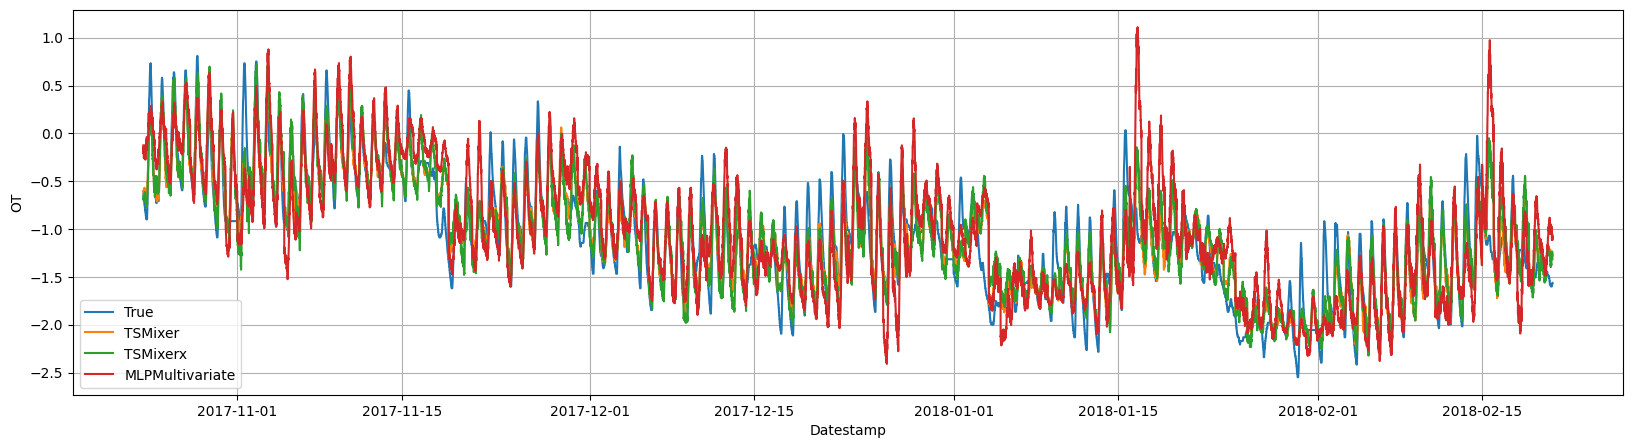

TSMixer horizon 96 - MAE: 0.250
TSMixer horizon 96 - MSE: 0.163
TSMixerx horizon 96 - MAE: 0.257
TSMixerx horizon 96 - MSE: 0.170
MLPMultivariate horizon 96 - MAE: 0.355
MLPMultivariate horizon 96 - MSE: 0.330


2024-09-10 06:40:39,417	INFO worker.py:1783 -- Started a local Ray instance.
2024-09-10 06:40:41,263	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-09-10_06-40-37   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-09-10_06-40-37
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-09-10_06-40-37_960760_3905/artifacts/2024-09-10_06-40-41/_train_tune_2024-09-10_06-40-37/driver_artifacts`


(_train_tune pid=84252) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=84252)   return torch.load

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, train_loss_step=0.244, train_loss_epoch=0.293]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=84252) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=0, train_loss_step=0.271, train_loss_epoch=0.404, valid_loss=0.257]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=84252) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=0, train_loss_step=0.307, train_loss_epoch=0.323, valid_loss=0.244]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=84252) 
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.270, valid_loss=0.240]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=84252) 
Validation DataLoader 

2024-09-10 06:48:38,500	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=84252) `Trainer.fit` stopped: `max_steps=500` reached.


(_train_tune pid=84252) 
Epoch 499: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=0.236]


(_train_tune pid=86323) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=86323)   return torch.load

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, train_loss_step=0.264, train_loss_epoch=0.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=86323) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=0, train_loss_step=0.285, train_loss_epoch=0.419, valid_loss=0.253]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=86323) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=0, train_loss_step=0.325, train_loss_epoch=0.340, valid_loss=0.246]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=86323) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, train_loss_step=0.272, train_loss_epoch=0.291, valid_loss=0.245]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [

2024-09-10 07:08:50,328	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=86323) 
Epoch 1299: 100%|██████████| 1/1 [00:09<00:00,  0.10it/s, v_num=0, train_loss_step=0.244, train_loss_epoch=0.244, valid_loss=0.235]


(_train_tune pid=91385) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=91385)   return torch.load

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, v_num=0, train_loss_step=0.335, train_loss_epoch=0.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=91385) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, train_loss_step=0.316, train_loss_epoch=0.476, valid_loss=0.254]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=91385) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, train_loss_step=0.340, train_loss_epoch=0.350, valid_loss=0.245]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=91385) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, train_loss_ste

In [ ]:
!pip install neuralforecast datasetsforecast

import pandas as pd
from datasetsforecast.long_horizon import LongHorizon

# Load ETTm2 benchmark dataset, or adapt this for your data
Y_df, X_df, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# Merge exogenous features with target data
X_df['ds'] = pd.to_datetime(X_df['ds'])
Y_df = Y_df.merge(X_df, on=['unique_id', 'ds'], how='left')

# Make validation and test splits
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

# Y_df contains the time series data (target values and exogenous features)
print(Y_df.head())

from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS, MLPMultivariate
from neuralforecast.losses.pytorch import MAE

# Set model hyperparameters
horizon = 96
input_size = 512

# Define the models
models = [
    TSMixer(h=horizon,
            input_size=input_size,
            n_series=7,
            max_steps=1000,
            val_check_steps=100,
            early_stop_patience_steps=5,
            scaler_type='identity',
            valid_loss=MAE(),
            random_seed=12345678,
           ),
    TSMixerx(h=horizon,
            input_size=input_size,
            n_series=7,
            max_steps=1000,
            val_check_steps=100,
            early_stop_patience_steps=5,
            scaler_type='identity',
            dropout=0.7,
            valid_loss=MAE(),
            random_seed=12345678,
            futr_exog_list=['ex_1', 'ex_2', 'ex_3', 'ex_4'],
           ),
    MLPMultivariate(h=horizon,
            input_size=input_size,
            n_series=7,
            max_steps=1000,
            val_check_steps=100,
            early_stop_patience_steps=5,
            scaler_type='standard',
            hidden_size=256,
            valid_loss=MAE(),
            random_seed=12345678,
           )
]

# Instantiate a NeuralForecast object
nf = NeuralForecast(models=models, freq='15min')

# Perform cross-validation to train and validate models
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)

# Reset the index for plotting purposes
Y_hat_df = Y_hat_df.reset_index()

import matplotlib.pyplot as plt

# Plot forecasts for the 'OT' variable across all models
Y_plot = Y_hat_df[Y_hat_df['unique_id'] == 'OT']
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_plot['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
for model in models:
    plt.plot(Y_plot['ds'], Y_plot[f'{model}'], label=f'{model}')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()
plt.show()

from neuralforecast.losses.numpy import mse, mae

# Compute MAE and MSE for each model
for model in models:
    mae_model = mae(Y_hat_df['y'], Y_hat_df[f'{model}'])
    mse_model = mse(Y_hat_df['y'], Y_hat_df[f'{model}'])
    print(f'{model} horizon {horizon} - MAE: {mae_model:.3f}')
    print(f'{model} horizon {horizon} - MSE: {mse_model:.3f}')

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.auto import AutoTSMixer, AutoTSMixerx

# Define hyperparameter search space
tsmixer_config = {
       "input_size": input_size,
       "max_steps": tune.choice([500, 1000, 2000]),
       "val_check_steps": 100,
       "early_stop_patience_steps": 5,
       "learning_rate": tune.loguniform(1e-4, 1e-2),
       "n_block": tune.choice([1, 2, 4, 6, 8]),
       "dropout": tune.uniform(0.0, 0.99),
       "ff_dim": tune.choice([32, 64, 128]),
       "scaler_type": 'identity',
    }

# Initialize AutoTSMixer with the search space
model = AutoTSMixer(h=horizon, n_series=7, loss=MAE(), config=tsmixer_config, num_samples=10, search_alg=HyperOptSearch(), backend='ray', valid_loss=MAE())

# Train using hyperparameter optimization
nf = NeuralForecast(models=[model], freq='15min')
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)


In [ ]:
# Evaluation code
for idx,col in enumerate(test_labels.columns):
  cm = confusion_matrix(test_labels[col].values,yhat[:,idx])
  cr = classification_report(test_labels[col].values,yhat[:,idx])
  print(f"Label: {col} \nconf\n {cm}, \nreport\n {cr}\n")


What you can say about the results?

# This is it!
We hope you enjoyed this notebook.
Please share your thoughts and impressions, and send us a link to your notebook.
Talk to you soon:)